In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv("bike-sharing-dataset.csv")
print(data.info())

data["date_time"] = pd.to_datetime(data["date_time"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_time   17544 non-null  object 
 1   holiday     17544 non-null  float64
 2   workingday  17544 non-null  float64
 3   weather     17544 non-null  object 
 4   temp        17544 non-null  float64
 5   atemp       17544 non-null  float64
 6   hum         17544 non-null  float64
 7   windspeed   17544 non-null  float64
 8   users       17544 non-null  float64
 9   month       17544 non-null  int64  
 10  hour        17544 non-null  int64  
 11  weekday     17544 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 1.6+ MB
None


In [13]:
# Hàm tạo time series data
def create_ts_data(data, window_size):
    for i in range(1, window_size + 1):
        data["users_{}".format(i)] = data["users"].shift(i)
    data = data.dropna(axis=0)
    return data

# Tạo time series data để dựa trên số lượng users của 24 giờ trước, dự đoán số lượng users của giờ thứ 25
window_size = 24
data = create_ts_data(data, window_size)
data

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,...,users_15,users_16,users_17,users_18,users_19,users_20,users_21,users_22,users_23,users_24
24,2011-01-02 00:00:00,0.0,0.0,mist,18.86,22.725,88.0,19.9995,17.0,1,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0,16.0
25,2011-01-02 01:00:00,0.0,0.0,mist,18.04,21.970,94.0,16.9979,17.0,1,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0,40.0
26,2011-01-02 02:00:00,0.0,0.0,mist,17.22,21.210,100.0,19.0012,9.0,1,...,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0,32.0
27,2011-01-02 03:00:00,0.0,0.0,mist,18.86,22.725,94.0,12.9980,6.0,1,...,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0,13.0
28,2011-01-02 04:00:00,0.0,0.0,mist,18.86,22.725,94.0,12.9980,3.0,1,...,94.0,84.0,56.0,36.0,14.0,8.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,...,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0,72.0,102.0
17540,2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,...,9.0,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0,72.0
17541,2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,...,40.0,9.0,3.0,1.0,11.0,19.0,34.0,49.0,36.0,47.0
17542,2012-12-31 22:00:00,0.0,1.0,clear,10.66,13.635,56.0,8.9981,61.0,12,...,85.0,40.0,9.0,3.0,1.0,11.0,19.0,34.0,49.0,36.0


In [14]:
# Chọn các features vả target
x = data.drop(["date_time", "users"], axis=1)
y = data["users"]

# Chia bộ dữ liệu thành tập train và tập test
train_size = int(len(x) * 0.8)
x_train = x[:train_size]
x_test = x[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print(x_train)
print(y_train)
print(x_test)
print(y_test)

       holiday  workingday weather   temp   atemp    hum  windspeed  month  \
24         0.0         0.0    mist  18.86  22.725   88.0    19.9995      1   
25         0.0         0.0    mist  18.04  21.970   94.0    16.9979      1   
26         0.0         0.0    mist  17.22  21.210  100.0    19.0012      1   
27         0.0         0.0    mist  18.86  22.725   94.0    12.9980      1   
28         0.0         0.0    mist  18.86  22.725   94.0    12.9980      1   
...        ...         ...     ...    ...     ...    ...        ...    ...   
14035      0.0         1.0    mist  31.16  36.365   66.0     7.0015      8   
14036      0.0         1.0    mist  30.34  34.850   70.0     8.9981      8   
14037      0.0         1.0    mist  29.52  34.850   74.0     0.0000      8   
14038      0.0         1.0   clear  29.52  34.850   74.0     7.0015      8   
14039      0.0         1.0   clear  29.52  34.850   79.0     0.0000      8   

       hour  weekday  ...  users_15  users_16  users_17  users_

In [15]:
# Tiền xử lý dữ liệu
num_features = ["temp", "atemp", "hum", "windspeed"] + ['users_{}'.format(i) for i in range(1, window_size + 1)]
cat_features = ["holiday", "workingday", "weather", "month", "hour", "weekday"]
preprocessor = ColumnTransformer(transformers=[
    ("num_features", StandardScaler(), num_features),
    ("cat_features", OneHotEncoder(sparse_output=False), cat_features)
])
print(preprocessor)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temp', 'atemp', 'hum', 'windspeed',
                                  'users_1', 'users_2', 'users_3', 'users_4',
                                  'users_5', 'users_6', 'users_7', 'users_8',
                                  'users_9', 'users_10', 'users_11', 'users_12',
                                  'users_13', 'users_14', 'users_15',
                                  'users_16', 'users_17', 'users_18',
                                  'users_19', 'users_20', 'users_21',
                                  'users_22', 'users_23', 'users_24']),
                                ('cat_features',
                                 OneHotEncoder(sparse_output=False),
                                 ['holiday', 'workingday', 'weather', 'month',
                                  'hour', 'weekday'])])


In [16]:
# Xây dựng mô hình Linear Regression
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Huấn luyện mô hình
model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  StandardScaler(),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed', 'users_1',
                                                   'users_2', 'users_3',
                                                   'users_4', 'users_5',
                                                   'users_6', 'users_7',
                                                   'users_8', 'users_9',
                                                   'users_10', 'users_11',
                                                   'users_12', 'users_13',
                                                   'users_14', 'users_15',
                                                   'users_16', 'users_17',
                                                   'users_18', 'users_19',
                                                   'users_20', 'users_21',
                                                   'users_22', 'users_23',
                                                   'users_24']),
                                                 ('cat_features',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['holiday', 'workingday',
                                                   'weather', 'month', 'hour',
                                                   'weekday'])])),
                ('regressor', LinearRegression())])

In [17]:
# Dự đoán
y_predict = model.predict(x_test)
for i, j in zip(y_predict, y_test):
    print("Predicted value: {}. Actual value: {}".format(i, j))

Predicted value: 50.37223815917969. Actual value: 58.0
Predicted value: 10.310348510742188. Actual value: 23.0
Predicted value: 48.17497253417969. Actual value: 6.0
Predicted value: 39.17106628417969. Actual value: 7.0
Predicted value: 26.423751831054688. Actual value: 7.0
Predicted value: 46.13407897949219. Actual value: 43.0
Predicted value: 139.08470153808594. Actual value: 173.0
Predicted value: 369.52574157714844. Actual value: 482.0
Predicted value: 635.8899383544922. Actual value: 737.0
Predicted value: 510.16954040527344. Actual value: 341.0
Predicted value: 190.0541229248047. Actual value: 214.0
Predicted value: 245.99729919433594. Actual value: 239.0
Predicted value: 270.8444061279297. Actual value: 280.0
Predicted value: 266.0821990966797. Actual value: 313.0
Predicted value: 279.3790740966797. Actual value: 236.0
Predicted value: 217.30442810058594. Actual value: 278.0
Predicted value: 414.8879852294922. Actual value: 441.0
Predicted value: 718.5920257568359. Actual value: 

In [18]:
# Đánh giá mô hình
print("MAE: {}".format(mean_absolute_error(y_test, y_predict)))
print("MSE: {}".format(mean_squared_error(y_test, y_predict)))
print("R2: {}".format(r2_score(y_test, y_predict)))

MAE: 48.746747069162865
MSE: 4811.616731667364
R2: 0.900881730880281


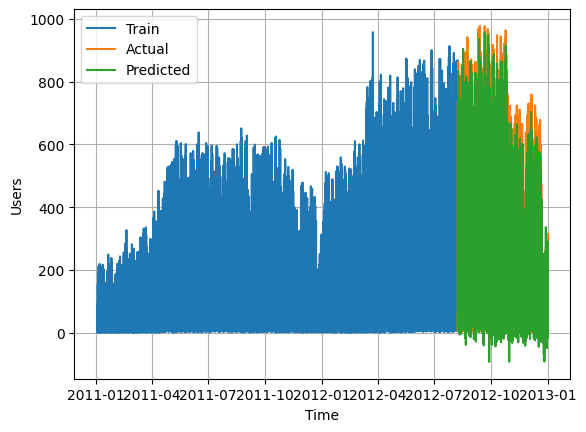

In [19]:
# Trực quang hóa dữ liệu
fig, ax = plt.subplots()
ax.plot(data["date_time"][:train_size], y_train.values, label="Train")
ax.plot(data["date_time"][train_size:], y_test.values, label="Actual")
ax.plot(data["date_time"][train_size:], y_predict, label="Predicted")
ax.set_xlabel("Time")
ax.set_ylabel("Users")
ax.legend()
ax.grid()
plt.show()